##### Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from  imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

##### The dataset

In [4]:
path= r'C:\Users\HP\Desktop\project_intern\data\Kaggle_Training_Dataset_v2.csv'  # Use the path of your downloaded dataset for avoiding errors
train_data= pd.read_csv(path,index_col=0)
train_data.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


##### Data Preprocessing

In [3]:
train_data= train_data.dropna()

cat_features = train_data.select_dtypes(include=['object'])
num_features = train_data.select_dtypes(include=np.number)

for col in cat_features:
    cat_features[col].replace('No',0,inplace=True)
    cat_features[col].replace('Yes',1,inplace=True)

train_data= pd.concat([num_features,cat_features],axis=1)

In [4]:
X= train_data.drop(['went_on_backorder','forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)
y= train_data['went_on_backorder']

scaler= StandardScaler()

skf= StratifiedKFold(random_state=42,shuffle=True)

##### Model Training

In [28]:
model_performance= pd.DataFrame(columns=['Model Name','AUC_ROC_Score','AUC_PR_Score'])

##### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
log_model= LogisticRegression(random_state=42)

roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    log_model.fit(X_train_scaled,y_train)
    y_pred= log_model.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[0]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')


Roc_score: 0.6153397783725817
PR_score: 0.011334460512311986


##### Logistic Regression with Smote

In [31]:
log_model_sm= LogisticRegression(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    X_train_scaled = scaler.fit_transform(X_train_sm)
    X_val_scaled = scaler.transform(X_val)

    log_model_sm.fit(X_train_scaled,y_train_sm)
    y_pred= log_model_sm.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[1]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.7322890575509036
PR_score: 0.02640085600274634


##### Logistic Regression with RandomOverSampling

In [32]:
log_model_ovr= LogisticRegression(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    X_train_scaled = scaler.fit_transform(X_train_ovr)
    X_val_scaled = scaler.transform(X_val)

    log_model_ovr.fit(X_train_scaled,y_train_ovr)
    y_pred= log_model_ovr.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[2]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.7651813055590945
PR_score: 0.026936183231162942


##### Logistic Regression with RandomUnderSampling

In [33]:
log_model_und= LogisticRegression(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_und)
    X_val_scaled = scaler.transform(X_val)

    log_model_und.fit(X_train_scaled,y_train_und)
    y_pred= log_model_und.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[3]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.7584658620343272
PR_score: 0.02521353086744395


##### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt_model= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    dt_model.fit(X_train,y_train)
    y_pred= dt_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[4]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.706307181009603
PR_score: 0.2676490458156974


##### Decision Tree with Smote

In [35]:
dt_model_sm= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    dt_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= dt_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[5]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.7223836255030249
PR_score: 0.2657851656063704


##### Decision Tree with RandomOverSampling

In [36]:
dt_model_ovr= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    dt_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= dt_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[6]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.6905088516159508
PR_score: 0.25818752114723775


##### Decision Tree with RandomUnderSampling

In [37]:
dt_model_und= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    dt_model_und.fit(X_train_und,y_train_und)
    y_pred= dt_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[7]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8659111206291195
PR_score: 0.4489681844677606


##### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    rf_model.fit(X_train,y_train)
    y_pred= rf_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[8]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

NameError: name 'model_performance' is not defined

##### Random Forest with Smote

In [39]:
rf_model_sm = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    rf_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= rf_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[9]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9338112994030162
PR_score: 0.2293660331635677


##### Random Forest with RandomOverSampling

In [40]:
rf_model_ovr = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    rf_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= rf_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[10]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9220169247971753
PR_score: 0.22726457666799987


##### Random Forest with RandomUnderSampling

In [41]:
rf_model_und = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    rf_model_und.fit(X_train_und,y_train_und)
    y_pred= rf_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[11]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9567460775407799
PR_score: 0.2031432299139842


##### Gradient Boosting

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    gb_model.fit(X_train,y_train)
    y_pred= gb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[12]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9298535050869157
PR_score: 0.18038413057930797


##### Gradient Boosting with Smote

In [43]:
gb_model_sm = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    gb_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= gb_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[13]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9331519966699213
PR_score: 0.1440626175098369


##### Gradient Boosting with RandomOverSampling

In [44]:
gb_model_ovr = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    gb_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= gb_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[14]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9397740099054548
PR_score: 0.1645495454423192


##### Gradient Boosting with RandomUnderSampling

In [45]:
gb_model_und = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    gb_model_und.fit(X_train_und,y_train_und)
    y_pred= gb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[15]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9392238077162596
PR_score: 0.163110121920178


##### XGBoost

In [46]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    xgb_model.fit(X_train,y_train)
    y_pred= xgb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[16]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9536580108609174
PR_score: 0.2674913672956138


##### XGBoost with Smote

In [47]:
xgb_model_sm = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    xgb_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= xgb_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[17]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.936111759298905
PR_score: 0.15086223958895384


##### XGBoost with RandomOverSampling

In [48]:
xgb_model_ovr = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    xgb_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= xgb_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[18]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9543839827969116
PR_score: 0.2335705753030965


##### XGBoost with RandomUnderSampling

In [49]:
xgb_model_und = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    xgb_model_und.fit(X_train_und,y_train_und)
    y_pred= xgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[19]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9514842310162717
PR_score: 0.16383614966054974


##### Training Scores of different models

In [50]:
model_performance

,Model Name,AUC_ROC_Score,AUC_PR_Score
0,Logistic,0.615340,0.011334
1,Logistic with Smote,0.732289,0.026401
2,Logistic with RandomOverSampling,0.765181,0.026936
3,Logistic with RandomUnderSampling,0.758466,0.025214
4,CART,0.706307,0.267649
5,CART with Smote,0.722384,0.265785
6,CART with RandomOverSampling,0.690509,0.258188
7,CART with RandomUnderSampling,0.865911,0.448968
8,RF,0.929219,0.408824
9,RF with Smote,0.933811,0.229366


##### Model Testing

In [5]:
path_test= r"C:\Users\HP\Desktop\intern\data\Kaggle_Test_Dataset_v2.csv"        # Use the path of your downloaded dataset for avoiding errors
test_data= pd.read_csv(path,index_col=0)
test_data.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


##### Data Preprocessing

In [6]:
test_data= test_data.dropna()

cat_features = test_data.select_dtypes(include=['object'])
num_features = test_data.select_dtypes(include=np.number)

for col in cat_features:
    cat_features[col].replace('No',0,inplace=True)
    cat_features[col].replace('Yes',1,inplace=True)

test_data= pd.concat([num_features,cat_features],axis=1)

X_test= test_data.drop(['went_on_backorder','forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)
y_test= test_data['went_on_backorder']

scaler = StandardScaler()

In [55]:
def evaluate_estimators(estimators, X_test, y_test):
    roc_scores = []
    pr_scores = []

    X_scale= scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    for estimator in estimators:
        if estimator in [log_model,log_model_sm,log_model_ovr,log_model_und]:
            y_pred = estimator.predict_proba(X_test_scaled)[:, 1]
        else:
            y_pred = estimator.predict_proba(X_test)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        auc_pr = auc(recall, precision)
        pr_scores.append(auc_pr)

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_roc = auc(fpr, tpr)
        roc_scores.append(auc_roc)

    test_scores = pd.DataFrame({
        'AUC_ROC_test':roc_scores,
        'AUC_PR_test':pr_scores
    })
    return test_scores


In [56]:
test_scores= evaluate_estimators([log_model,log_model_sm,log_model_ovr,log_model_und,
                     dt_model,dt_model_sm,dt_model_ovr,dt_model_und,
                     rf_model,rf_model_sm,rf_model_ovr,rf_model_und,
                     gb_model,gb_model_sm,gb_model_ovr,gb_model_und,
                     xgb_model,xgb_model_sm,xgb_model_ovr,xgb_model_und],X_test,y_test)

##### Models performance comparison on train and test data

In [57]:
model_performance= pd.concat([model_performance,test_scores],axis=1)
model_performance

,Model Name,AUC_ROC_Score,AUC_PR_Score,AUC_ROC_test,AUC_PR_test
0,Logistic,0.615340,0.011334,0.616663,0.011416
1,Logistic with Smote,0.732289,0.026401,0.745993,0.026225
2,Logistic with RandomOverSampling,0.765181,0.026936,0.762537,0.026645
3,Logistic with RandomUnderSampling,0.758466,0.025214,0.704449,0.017599
4,CART,0.706307,0.267649,0.940375,0.784452
5,CART with Smote,0.722384,0.265785,0.941316,0.729826
6,CART with RandomOverSampling,0.690509,0.258188,0.936687,0.793658
7,CART with RandomUnderSampling,0.865911,0.448968,0.915462,0.497924
8,RF,0.929219,0.408824,0.985273,0.854139
9,RF with Smote,0.933811,0.229366,0.984605,0.631716


<Axes: >

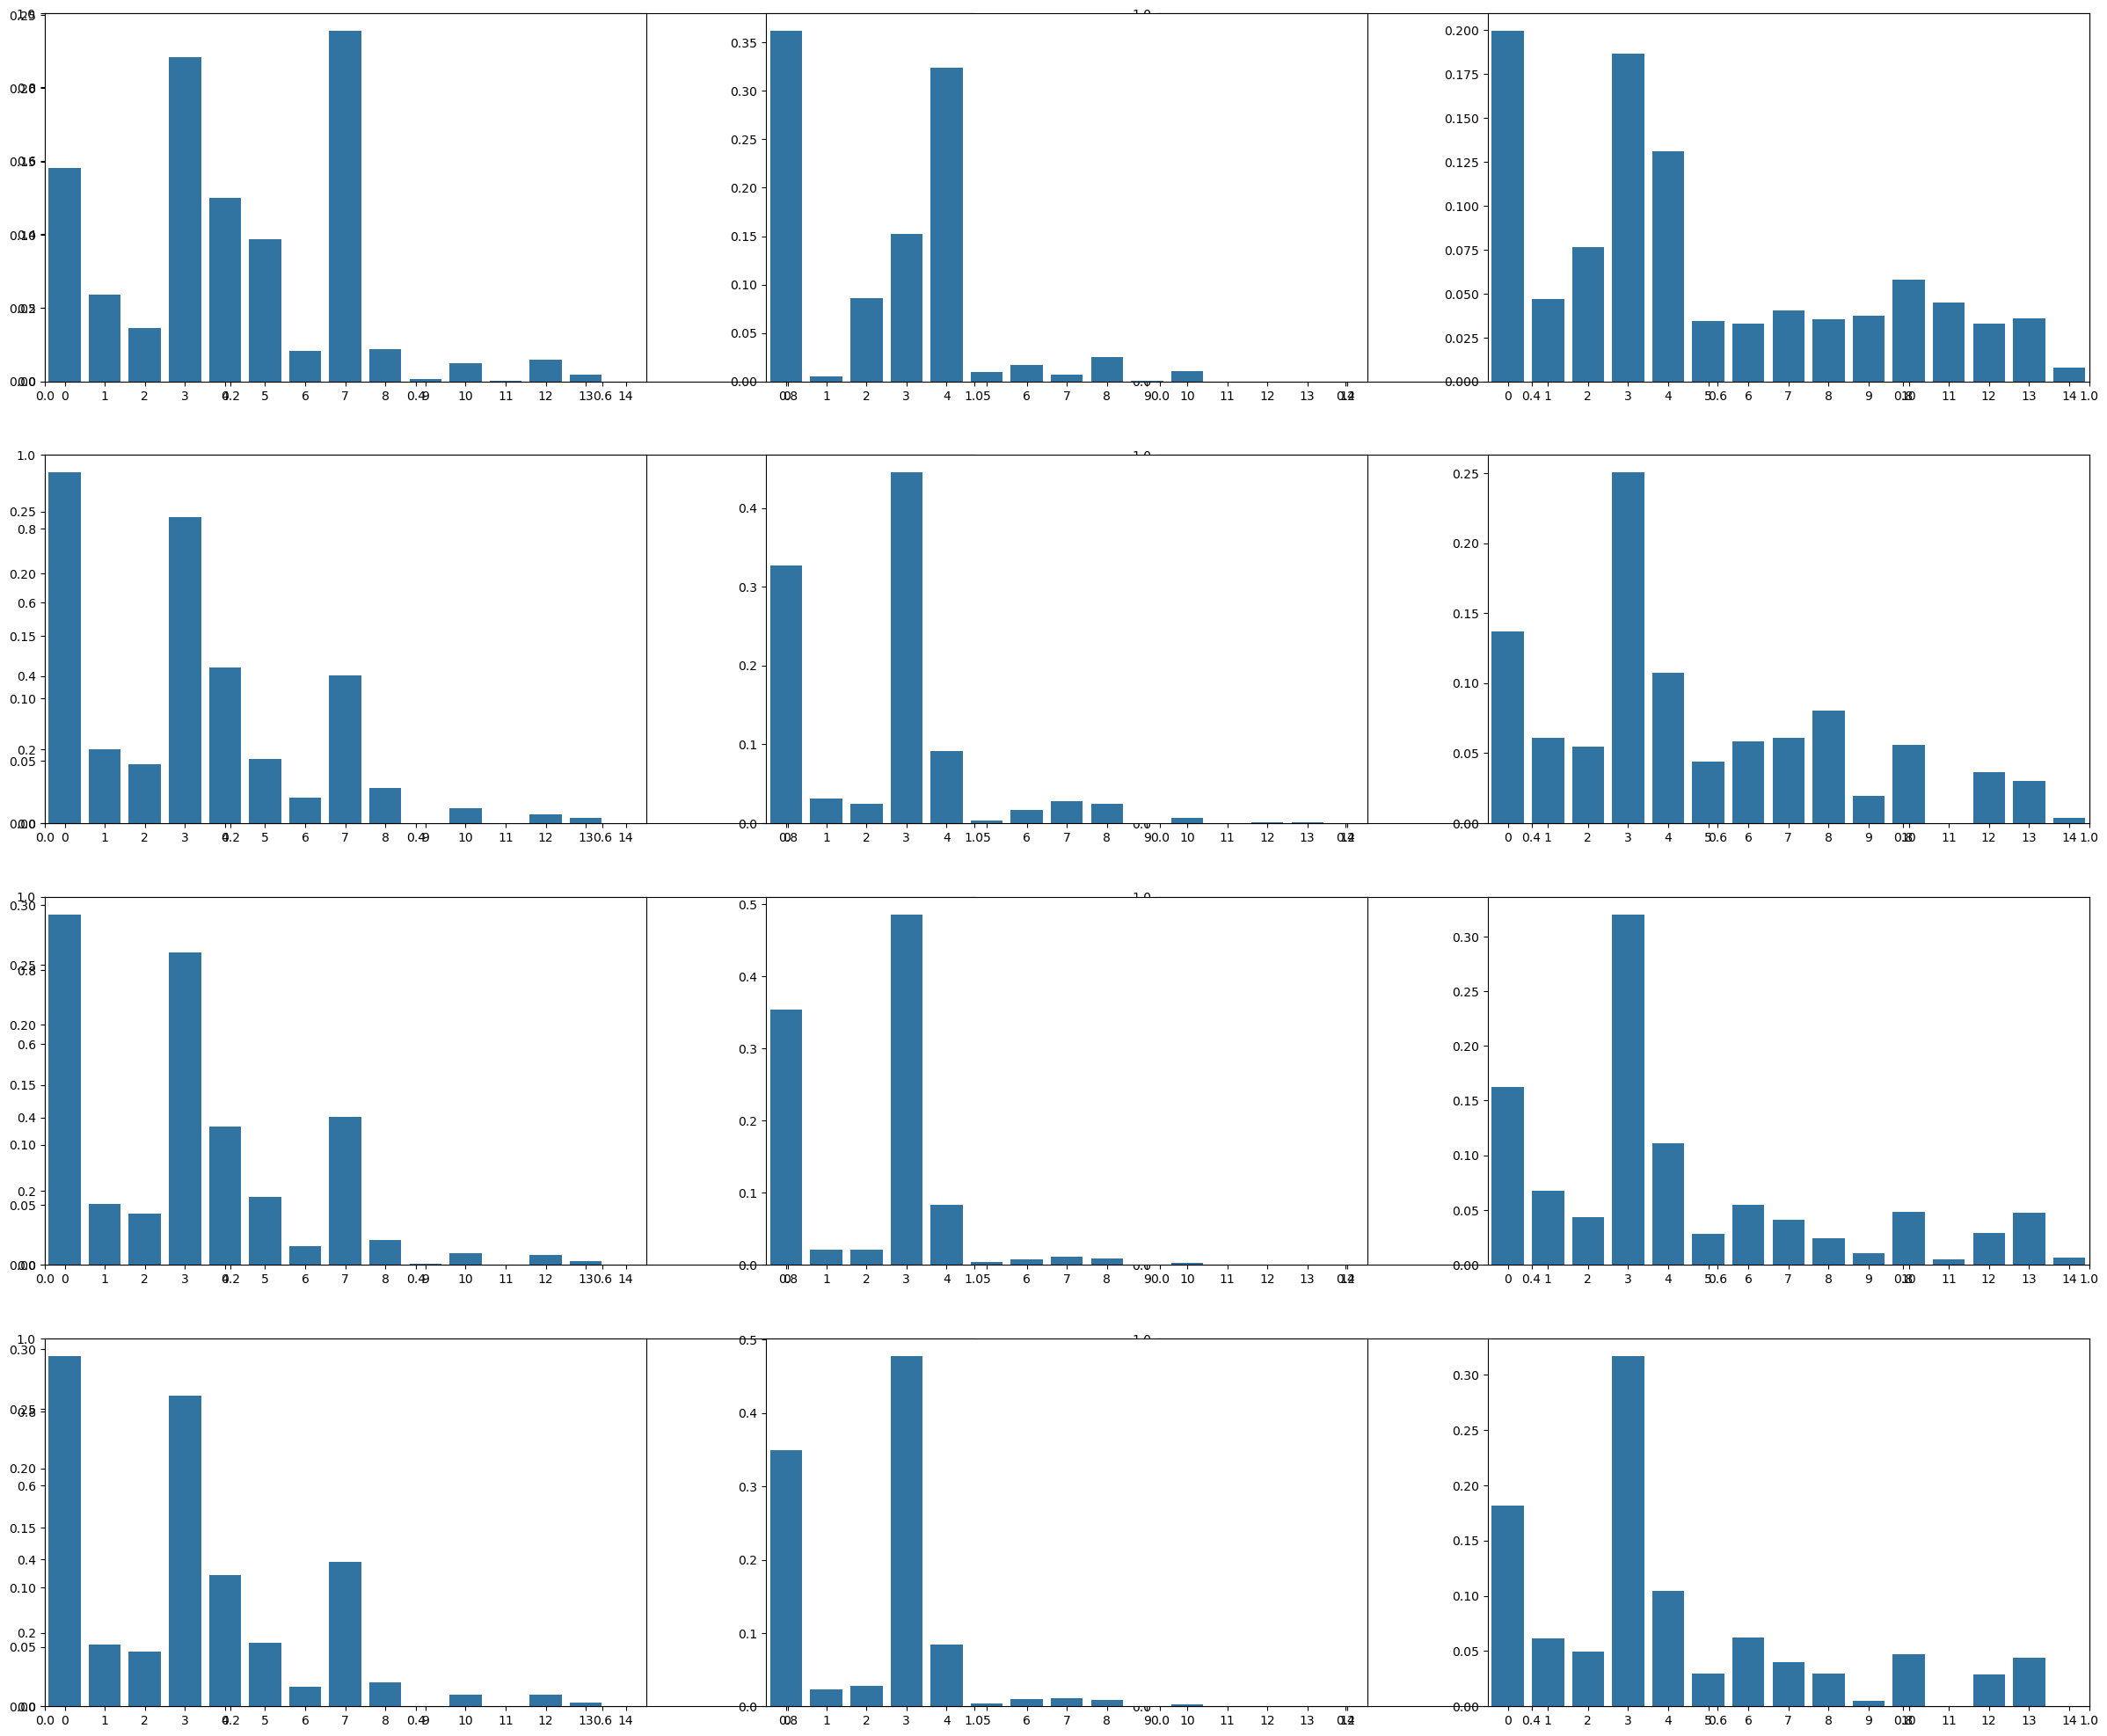

In [66]:
rf_importances= rf_model.feature_importances_
gb_importances= gb_model.feature_importances_
xgb_importances= xgb_model.feature_importances_
rf_importances_ovr = rf_model_ovr.feature_importances_
gb_importances_ovr = gb_model_ovr.feature_importances_
xgb_importances_ovr = xgb_model_ovr.feature_importances_
rf_importances_sme = rf_model_sm.feature_importances_
gb_importances_sme = gb_model_sm.feature_importances_
xgb_importances_sme= xgb_model_sm.feature_importances_
rf_importances_und = rf_model_und.feature_importances_
gb_importances_und = gb_model_und.feature_importances_
xgb_importances_und= xgb_model_und.feature_importances_

fig, axs = plt.subplots(nrows=4, ncols=3,figsize=(30,25))
plt.subplot(4,3,1)
sns.barplot(rf_importances)
plt.subplot(4,3,2)
sns.barplot(gb_importances)
plt.subplot(4,3,3)
sns.barplot(xgb_importances)
plt.subplot(4,3,4)
sns.barplot(rf_importances_sme)
plt.subplot(4,3,5)
sns.barplot(gb_importances_sme)
plt.subplot(4,3,6)
sns.barplot(xgb_importances_sme)
plt.subplot(4,3,7)
sns.barplot(rf_importances_ovr)
plt.subplot(4,3,8)
sns.barplot(gb_importances_ovr)
plt.subplot(4,3,9)
sns.barplot(xgb_importances_ovr)
plt.subplot(4,3,10)
sns.barplot(rf_importances_und)
plt.subplot(4,3,11)
sns.barplot(gb_importances_und)
plt.subplot(4,3,12)
sns.barplot(xgb_importances_und)